# GANocracy: A Practioner's Guide to Training GANs in 2019

**Author**: `Alex Andonian`

## Introduction

This tutorial will give a brief introduction to some of the more recent achievements of Generative Adversarial Networks (GANs), which have seen tremendous progress in their short 5 year lifespan. **Fun Fact:** GANs celebrate their 5th anniversary on May 26, 2019. The rapid progress of GANs' sucess in image synthesis is particularly impressive:

![GAN Progress in Image Synthesis](assets/progress.jpg)

In light of the enormous volume of work devoted to GANs, it is nearly impossible to cover everything. At the time of writing, the author counted at least 46 different named GANs alone. Instead, we will focus on one particular line of research that has recently culminated in state-of the art Imagenet generation.

- **Deep Convolutional GANs (DCGANs)**: introduced convolutions to GAN architectures, forming the basis for image GAN architectures to come.
- **Conditional GANs (cGANs)**: Generate images of different categories.
- **Spectral Normalization (SNGANs)**: Improved training stability.
- **Self-Attention Mechanism (SAGANs)** for modeling long-range dependencies and handling diverse multi-class datasets.
- **Large Scale GAN training (BigGANs)**: achieves the current state-of-the-art on ImageNet generation. 

This tutorial is very much *for the practioner, by the practioner*. The goal is to prepare users with the tools and intuitions to take on the task of training large-scale, high-resolution GANs of their own. We will begin training a simplified version of the recent BigGAN architecture and walk through some techniques for monitoring and debugging the training process. Finally, we will demonstrate how to control sample generation using a fully pretrained BigGAN.

This tutorial assumes a basic understanding of GANs and how they work. If this is your very first introduction to GANs (and/or you find yourself with a growing list of questions), you may want to first review [PyTorch's DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), to which this serves as an extension. If  as well as a machine ready to run the latest release of PyTorch (1.1). For a general overview of GANs and how they work, please refer to [Insert Introduction Link]. For more detailed instructions on how to install PyTorch, please see these instructions [Insert Link to Setup.md].


## How to get the most out of this tutorial

For the **casual observer** just curious about learning more about recent GAN developments, this notebook along with the provided links to external references should be sufficiently serve an informative document. A powerful laptop or mainstream desktop computer should be enough for you to execute most of the computationally inexpensive (e.g. inference with pretrained generators) cells.

For the **interested practioner** keen on running the full notebook and playing around with different datasets and hyperparameters, a powerful desktop/server with at least one modern GPU is *highly* recommended, if not required. The median recommendation is 4-8 GPUs.

If you do not have access to the recommended computational resources, it is possible (and fairly easy) to create a sufficiently powerful Virtual Machine (VM) on one of several cloud providers. We provide brief instructions and suggestions on how to get up and running with the following providers:

- [Core Scientific](cloud/Core_Scientific.md)
- [Google Cloud] TODO
- [IBM Cloud](cloud/IBM_Cloud.md)

Nvidia and AWS also provide excellent offerings, but we are not able to provide specific instructions at this time.

For the **hardcore "GANologist"** determined to reproduce (and exceed) the performance of the latest state-of-the-art GANs, we recommend using this notebook as a thorough introduction and reference before stepping up to full-fledged (officially unofficial) implementations such as [BigGAN-PyTorch](https://github.com/ajbrock/BigGAN-PyTorch).

### System & Software Requirements
Linux, MacOS, and Windows machines are supported, but we strongly recommend Linux for performance and compatibility reasons. 

- PyTorch, version 1.1.0 (stable)
- torchvision (0.3.0)
- tqdm, numpy, scipy, h5py

### Recommendations
TODO

## Preliminaries
First, let's import the all of the  python packages we will use throughout the tutorial. In addition to standard import and PyTorch, we provide a small package called `ganocracy`, which aggregates a host of useful GAN specific functions and utilities in one place - a "one-stop-shop" for everything needed to get started with GANs. 

Almost all code shown in this notebook can be found inside the `ganocracy` package. We store actually implementations outside of the notebook so that bits and pieces can be conveniently incorporated into other projects, (without having to copy and paste from this notebook). For each snippet, the path to the real implementation is listed in the comments.

In [1]:
# IMPORTS
import os 
import sys
import numpy as np


# PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision


# GANOCRACY LIB
sys.path.append('../')
import ganocracy
from ganocracy.data import datasets as dset
from ganocracy.data import transforms
from ganocracy import metrics, models
from ganocracy.models import utils as mutils
from ganocracy.utils import visualizer as vutils

# NOTEBOOK-SPECIFIC IMPORTS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
try:
    %matplotlib inline
except: # if we are not in Jupyter, use the headless frontend
    matplotlib.use('Agg')
%config InlineBackend.figure_format = 'retina'

os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3'
print(os.environ['CUDA_VISIBLE_DEVICES'])

1,2,3


Below, we create a configuration dictionary `config`, which dictates how the entire notebook will run, and filled it with sensible defaults.

In [2]:
config = {

    # --------------
    # DATASET CONFIG
    # --------------
    'data_root': 'data',            # Root directory where datasets are stored.
    'dataset': 'ImageNet',          # Name of dataset. Choices: See below.
    'dataset_type': 'ImageHDF5',    # Type/format of dataset class. Choices: ['ImageFolder', 'ImageHDF5']
    'resolution': 64,               # Image size (H, W) in pixels. Choices: [32, 64, 128, ...]

    'split': 'train',               # Dataset split (train or val), if applicable.
    'download': True,               # If data is not found, download and cache it.
    'load_in_mem': True,            # Load entire dataset into RAM.
    
    # -----------------
    # DATALOADER CONFIG
    # -----------------
    'shuffle': True,                # Shuffle training data
    'batch_size': 512,              # Batch size per forward/backward pass.
    'num_workers': 8,               # Number of workers used for data loading.

    # ------------------
    # MODEL ARCHITECTURE
    # ------------------
    'GAN_type': 'DCGAN',    # Type of GAN. Choices: ['DCGAN', 'SNGAN', 'SAGAN', 'BigGAN', 'BigGANDeep']
    
    'G_ch': 96,             # Channel multiplier - scales number of features per conv in G and D
    'D_ch': 96,             # Typical choices: [64 (DCGAN, SN/SA-GAN), 96 (BigGAN), 128 (BigGANDeep)]
    
    'G_attn': 64,           # Resolution to insert self-attention (non-local) blocks.
    'D_attn': 64,           # Does not apply (ignored) for DCGAN and SNGAN.
    
    'dim_z': 120,           # Dimension of latent z vector.
    'hier': True,
    'shared_dim': 128,
    
    'G_init': 'ortho',      # Weight initialization method.
    'D_init': 'ortho',      # Choices: ['normal', 'xavier', 'ortho'].
    
    'G_n1': 'inplace_relu', # Activation function.
    'D_n1': 'inplace_relu', # Choices: ['relu', 'inplace_relu']
    'G_eval_mode': True,
    'ngpu': 1,
  
    # ---------------
    # TRAINING CONFIG
    # ---------------
    'num_epochs': 100,        # Number of training epochs (1 epoch = 1 presentation of full dataset).
    'num_D_steps': 1,         # Number of updates to Discriminator per 1 step of Generator.
    
    'num_G_accumulations': 4, # Number of gradient accumulations per step of G and D.
    'num_D_accumulations': 4, # Technique to spoof larger batch sizes.
    
    'loss_type': 'BCE',       # Loss function type. Choices ['BCE', 'hinge']
    
    # ----------------
    # OPTIMIZER CONFIG
    # ----------------
    'G_lr': 1e-4,            # Learning rates for G and D.
    'D_lr': 4e-4,            # Should be same 
    
    'G_betas': (0.5, 0.999), # Betas for Adam optimizers
    'D_betas': (0.5, 0.999),
    
    'ema': True,
    'use_ema': True,
    'ema_start': 20000,
    'test_every': 2000,
    'save_every': 1000,
    'num_best_copies': 5,
    'num_save_copies': 2,
    'seed': 0,
    'use_multiepoch_sampler': True,
    
    'TORCH_HOME': None,  # Path to where pretrained models are saved. Default: None => $HOME/.torch
}

config.update({
    # Update with standard number of classes
    # based on choice of dataset.
    'num_classes': {
        'celeba': 1,
        'CIFAR10': 10,
        'CIFAR100': 100,
        'ImageNet': 1000,
        'Places365': 365,
    }.get(config['dataset'], 1),
    
    # Prepare data; the Discriminator's batch size is all that needs to be passed
    # to the dataloader, as G doesn't require dataloading.
    # Note that at every loader iteration we pass in enough data to complete
    # a full D iteration (regardless of number of D steps and accumulations)
    'D_batch_size': config['batch_size'] * config['num_D_steps'] * config['num_D_accumulations'],
    
    # Determine whether or not GPUs are available.
    'device': torch.device("cuda:0" if (torch.cuda.is_available() and config['ngpu'] > 0) else "cpu")
})

## Data Preparation
In this tutorial, you are free to choose from a range of popular datasets ranging in difficulty and diversity. These include:  
- CelebA: 
- Cifar10/100
- [TODO include LSUN?]
- ImageNet
- Places365

By default, we will use the [Places365 dataset](http://places2.csail.mit.edu/) which contains more than 10 million images comprising 400+ unique scene categories. You can manually download the full dataset [here](http://places2.csail.mit.edu/download.html), although we provide standard PyTorch dataloaders that download, cache and preprocess several standard datasets as part of this tutorial. Therefore, preparing a dataloader can be accomplished with just a few lines:

In [3]:
def get_dataset(name, root_dir=None, resolution=128, filetype='tar'):
    if filetype == 'tar':
        url = dset.data_urls[name]['tar']
        data_dir = dset.load_data_from_url(url, root_dir)
        dataset = dset.ImageFolder(root=data_dir,
                                   transform=transforms.Compose([
                                       transforms.CenterCropLongEdge(),
                                       transforms.Resize(resolution),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))
                                    ]))
    elif filetype == 'hdf5':
        url = dset.data_urls[name]['hdf5'][resolution]
        hdf5_file = dset.load_data_from_url(url, root_dir)
        dataset = dset.ImageHDF5(hdf5_file)
    else:
        raise ValueError('Unreconized filetype: {}'.format(filetype))
    return dataset

# dataset = get_dataset(config['dataset'],
#                       root_dir=config['data_root'],
#                       resolution=config['resolution'])

# dataloader = torch.utils.data.DataLoader(dataset,
#                                          shuffle=config['shuffle'],
#                                          batch_size=config['batch_size'],
#                                          num_workers=config['num_workers'])
# vutils.visualize_data(dataloader)



In [4]:
# resolution = config['resolution']
# dataset = torchvision.datasets.ImageNet(config['data_root'],
#                                         split=config['split'],
#                                         download=config['download'],
#                                         transform=transforms.Compose([
#                                             transforms.CenterCropLongEdge(),
#                                             transforms.Resize(resolution),
#                                             transforms.ToTensor(),
#                                             transforms.Normalize((0.5, 0.5, 0.5),
#                                                                  (0.5, 0.5, 0.5))
#                                     ]))

In [5]:
# # We can use an image folder dataset the way we have it setup.
# # Create the dataset
if config['dataset'] in ['CIFAR10', 'CIFAR100']:
    image_size = 32
    CIFAR = getattr(torchvision.datasets, config['dataset'])
    dataset = CIFAR(root=config['data_root'], train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]))
elif config['dataset'] in ['CelebA']:
    CelebA = getattr(torchvision.datasets, config['dataset'])
    dataset = CelebA(root=config['data_root'],  download=config['download'],
                     transform=transforms.Compose([
                         transforms.Resize(config['resolution']),
                         transforms.CenterCrop(config['resolution']),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                     ]))
else:
    if config['dataset_type'] == 'ImageFolder':
        dataset = dset.ImageFolder(root=config['data_root'],
                                   download=config['download'],
                                   transform=transforms.Compose([
                                       transforms.Resize(config['resolution']),
                                       transforms.CenterCrop(config['resolution']),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    elif config['dataset_type'] == 'ImageHDF5':
        hdf5_name = '{}-{}.hdf5'.format(config['dataset'], config['resolution'])
        print(hdf5_name)
        hdf5_file = os.path.join(config['data_root'], hdf5_name)
        print(hdf5_file)
        hdf5_file = dset.make_hdf5(dataloader, config['data_root'], hdf5_name)
        dataset = dset.ImageHDF5(hdf5_file, load_in_mem=True)
        dataloader = torch.utils.data.DataLoader(dataset,
                                             shuffle=True,
                                             batch_size=D_batch_size,
                                             num_workers=workers, 
                                             drop_last=True)

# # Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'],
                                         shuffle=config['shuffle'], num_workers=config['num_workers'])
# gvutils.visualize_data(dataloader)
# # Decide which device we want to run on
device = config['device']

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(15, 15))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

ImageNet-64.hdf5
data/ImageNet-64.hdf5


NameError: name 'dataloader' is not defined

In [ ]:
hdf5_name = '{}-{}.hdf5'.format(config['dataset'], config['resolution'])
print(hdf5_name)
hdf5_file = os.path.join(config['data_root'], hdf5_name)
print(hdf5_file)
hdf5_file = dset.make_hdf5(dataloader, config['data_root'], hdf5_name)
dataset = dset.ImageHDF5(hdf5_file, load_in_mem=True)
dataloader = torch.utils.data.DataLoader(dataset,
                                     shuffle=config['shuffle'],
                                     batch_size=config['D_batch_size'],
                                     num_workers=config['num_workers'])

### Using your own data

If you would like to train a GAN on a your own custom dataset, subclassing [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is a sensible approach as it allows you to make use of PyTorch's dataloading utilities, including the multi-threaded DataLoader and transforms from above.

If your training data consist of image files, the [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class facilitates easy dataloading. Simply arrange your files in the following way:

    root/dogball/xxx.png
    root/dogball/xxy.png
    root/dogball/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
where each subdirectory of `root` is considered an image category containing examples of that category.

### Prepare data as single HDF5 file (optional, for additional performance)

If your dataset consists of large, high-resolution images, then repeatedly applying transforms to the raw images (cropping, resizing) results in many wasted CPU cycles. Furthermore, increasing your batchsize puts additional I/O strain on your filesystem. Together, these factors may produce a dataloading bottleneck where your GPUs consume data faster than your system can produce it. To remedy this, you may choose to prepare a pre-processed HDF5 version of your target dataset using the utilities provided. Moreover, if I/O still appears to be the bottleneck, you may choose to load the entire dataset into RAM by setting `load_in_mem` dataset kwargs to `True` (if your system can support this).

Another advantage to using a single, preprocessed HDF5 is the ease with which you can transfer data to multiple remote machines, which normally becomes cumbersome and time consuming when attempting large, distributed experiments.

In [ ]:
hdf5_name = '{}-{}.hdf5'.format(config['dataset'], config['resolution'])
print(hdf5_name)
hdf5_file = os.path.join(config['data_root'], hdf5_name)
print(hdf5_file)
hdf5_file = dset.make_hdf5(dataloader, config['data_root'], hdf5_name)
dataset = dset.ImageHDF5(hdf5_file, load_in_mem=config['load_in_mem'])
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=config['shuffle'],
                                         batch_size=config['D_batch_size'],
                                         num_workers=config['num_workers'])
vutils.visualize_data(dataloader)

### Preparing to measure sample quality during training

Typically, when training any sort of neural network, it is standard practice to monitor the value of the objective function (loss) throughout the course of the experiment. With GANs, it is also common to break the loss into individual components. However, the adversarial losses measure the competition between the generator and discriminator and do not necessarily reflect the image quality of generated samples. Without an objective measure of image quality, comparing models, monitoring progress and tuning models is near impossible.

In the early day of GAN research, samples were compared visually, which obviously has several issues (ratings could be highly subjective and biases, and evaluating at scale is difficult). On the other hand, objectively evaluating implicit generative models still remains difficult and an active area of investigation. Despite their notable flaws, researchers have recently settled on two popular metrics, which aim to capture image quality and diversity:

- **Inception Score (IS):** Score based on how confidently an ImageNet-pretrained InceptionV3 network can classify generated samples and the diversity of its predictions over large collection of samples. If a model produces samples that InceptionV3 can confidently classify, this contributes to a higher IS. A high diversity of classifications also contributes to a higher IS. 

- **Fréchet Distance (FID):** Measures the distance between two distributions. Here, an Inception Network is used to generate feature representations for both the real images from the dataset of interest and generated samples from the model. These feature distributions are model by multivariate Guassian distributions. The shorter the FréchetDistance between these two distributions, the more closely the fake images resemble the real ones. 

Summary

Higher IS values mean better image quality and diversity (usually).

Lower FID values mean better image quality and diversity.

#### Some Caveats
Since the InceptionV3 model is trained to classify ImageNet categories, Inception Score can be a very poor measure of quality on datasets other than ImageNet, although not completely uninformative. While the absolute scale of non-ImageNet based datasets might be lower (and not comparable), relative changes in inception score generally still correlate with image quality. An alternative, although not standardized, practice would be to train an Inception Classifier on the datset of interest, and use that trained network to compute inception scores instead.

Inception Scores are vuler
so you will likely want to use --which_best FID instead.

In [ ]:
# inception_moments_file = metrics.calculate_inception_moments(dataloader, config['data_root'], config['dataset'])

# Build Model

## Convolutional GANS 

[Deep Convolutional GANS](https://arxiv.org/abs/1511.06434) (DCGANs) represented a major step forward in the sucess of GAN image synthesis. It stands as one of the most popular and successfull baseline GAN architectures.

**Challenge:** Design a neural network architecture for efficient and stable image generation. 

**Solution:** A fully convolutional network that does away with max pooling and fully connected layers. Convolutions had already proven successful for disciminative computer vision tasks since they are well suited for handling the spatial structure of images, and were introduced to GANs in this paper. The design introduces several important architectural elements:

- **Strided (Transposed) Convolutions**: 

- **Batch normalization following convolutional layers** works to combat poor initialization schemes and mode collapes. *Recall, batch norm works by normalizing the inputs features to have zero mean and unit variance.*

Below is a figure depicting the design of the Generator:
![DCGAN Generator Architecure](assets/dcgan_generator.png)

Almost all GANs used for image synthesis now follow some variation of DCGAN, although some modern architectures deviate from these recommendation. None-the-less, due to its simplicity and success, DCGAN remains a good start point for a new project.

The generator consists of `GBlocks`, which progressively increase the spatial dimensions while decreasing the feature volume depth.

The 

*Mode Collapse*: When the generator falls into a situation where it produces an extremely limited set output patterns ("modes") despite maintaining diversity on input noise. 

Generator(
  (class_linear): Linear(in_features=2, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=16384, bias=True)
  (GBlocks): ModuleList(
    (0): GBlock(
      (conv): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(1024, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): SNLinear(in_features=128, out_features=1024, bias=False)
        (beta_embed): SNLinear(in_features=128, out_features=1024, bias=False)
      )
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): SNLinear(in_features=128, out_features=512, bias=False)
        (beta_embed): SNLinear(in_featu

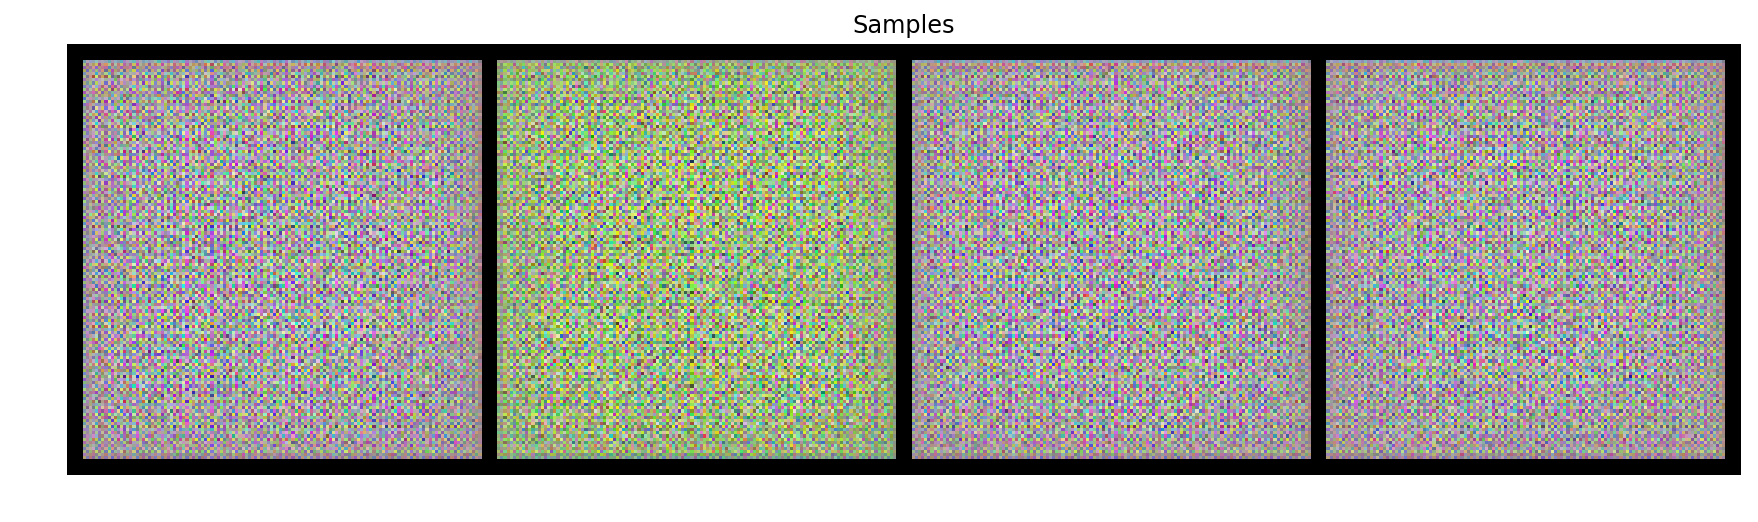

In [6]:
# Instantiate DCGAN Generator instance.
# TODO: Add appropriate args, plus option to download pretrained model.
G = models.dcgan.Generator()
print(G)  # View model architecture.

# Create some input tensors.
z = torch.randn(4, G.dim_z)
y = torch.randint(G.num_classes, (4,))

# Generate samples while capturing the sizes of intermediate outputs.
output, names, sizes = mutils.hook_sizes(G, inputs=(z, y), verbose=True)
vutils.visualize_samples(output)

In [ ]:
####################################################################
# DCGAN Generator
####################################################################

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=4, stride=2,
                                       padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(True)
        
    def forward(self, input):
        """Forward method of GBlock.
        
        This block increases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, 2*H, 2*W]
        """
        
        x = self.conv(input)
        x = self.bn(x)
        out = self.act(x)
        return out

class DCGANGenerator(nn.Module):
    """DCGAN Generator.
    """
    
    # Maps output resoluton to number of GBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, dim_z=128, resolution=128, G_ch=64, 
                block=GBlock):
        super().__init__()
        
        self.G_ch = G_ch
        self.dim_z = dim_z

        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]
        self.ch_nums += self.ch_nums[-1:]
        self.ch_nums = list(reversed(self.ch_nums))
        
        self.linear = nn.Linear(dim_z, G_ch * self.ch_nums[0] * 4**2)
        self.GBlocks = nn.Sequential(*[
            block(G_ch * in_c, G_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)  # RGB image has 3 channels
        self.tanh = nn.Tanh()                            # "Squashes" out to be in range[-1, 1]
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.GBlocks(x)
        return self.tanh(self.out(x))
    
dim_z = 128
z = torch.rand(10, config['dim_z'])
G = DCGANGenerator(dim_z=config['dim_z'], resolution=config['resolution'])
print(G)
print('output shape:', G(z).shape)

`DBlocks`, found in the discriminator, are near perfect inverses to `GBlocks`, trading spatial dimension for feature depth, with the exception of using LearkyReLUs instead of ReLUs for their nonlinearities.

In [ ]:
####################################################################
# DCGAN Discriminator
####################################################################

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        """Forward method of DBlock.
        
        This block decreases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, H/2, W/2]
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class DCGANDiscriminator(nn.Module):
    """DCGAN discriminator."""
    
    # Maps output resoluton to number of DBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, resolution=128, D_ch=64, block=DBlock):
        super().__init__()
        self.D_ch = D_ch
        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]
        self.input_layer = nn.Conv2d(3, D_ch, 3, padding=1)
        
        self.DBlocks = nn.Sequential(*[
            block(D_ch * in_c, D_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        
        self.out = nn.Conv2d(D_ch * self.ch_nums[-1], 1, 3, 1, 0)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.DBlocks(x)
        x = self.act(torch.mean(self.out(x), [2, 3]))
        return x

    
x = torch.rand(10, 3, config['resolution'], config['resolution'])
D = Discriminator(resolution=config['resolution'])
print(D)
print('output shape:', D(x).shape)

## Conditional GANs (cGANs)

Conditional GANs are an interesting extension to the GAN framework, allowing for much greater control over the final output of the generator. Here, both the generator and discriminator are conditioned on some data $y$ (class label or data from some other modality). For example, perhaps you aren't just interested in generating various MNIST digits, but rather would like to generate examples of the digit "5" only. 

**Challenge:** What is best approach to incorporating additional additional information we have about our data and leverage it to improve sample quality and exert finer control over the generator.

#### Dicriminator
Researchers have tried various approaches to incorporating conditional information into the discriminator, including concatenating class embeddings at various stages of the network (input, hidden). Others have  
The progression of approaches to conditional GAN discriminators is nicely summarized in the following figure:

![Approaches to conditional GANs](assets/cGANs.png)



In [ ]:
class cGANDiscriminator(Discriminator):
    """cGAN Projection discriminator."""
    
    # Maps output resoluton to number of DBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, num_classes=1000, resolution=128, D_ch=64, block=DBlock):
        super().__init__(resolution=resolution, D_ch=D_ch, block=block)
        
        self.embed = nn.Embedding(num_classes, self.ch_nums[-1])
        self.linear = nn.Linear(self.ch_nums[-1], 1)

    def forward(self, x, y):
        h = self.input_layer(h)
        h = self.DBlocks(h)
        h = self.out(h)
        
        # Apply global sum pooling
        h = torch.sum(self.act(h), [2, 3])
        
        # Initial class-unconditional output.
        out = self.linear(h)  
        
        # Get projection of final featureset onto class vectors and add to evidence
        out = out + torch.sum(self.embed(y) * h, 1, keepdim=True)
        return out

#### Generator
For the most part, methods for conditioning the generator have mirrored their discriminator counterpart. However, more recently, [INSERT NAME AND CITATION] have conditioned the generator by way of **Class Conditional Batchnorm**. Here,
it behaves much like traditional batchnorm *except* that it learns per-class gain weights $\gamma$ and bias $\beta$ to be applied to the output. Note that the running input statistics (mean/var) are not class dependent in conditional batchnorm.


```python
# Found in:
# ganocracy/layers/norms.py

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, eps=1e-4, momentum=0.1,
                 linear_func=SNLinear):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False, eps=eps, momentum=momentum)
        self.gamma_embed = linear_func(num_classes, num_features, bias=False)
        self.beta_embed = linear_func(num_classes, num_features, bias=False)

    def forward(self, x, y):
        # First, compute standard batchnorm stats.
        out = self.bn(x)
        
        # Learn class specific scale and shift.
        gamma = self.gamma_embed(y) + 1  #  BigGAN gain projections are centered at 1.
        beta = self.beta_embed(y)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out
```

## Spectral Normalization (SNGANs)


**Challenge**: Adversarial training is a highly dynamic characterized by instability, particularly in the Discriminator network.

Miyato et al proposed a normalization technique called [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957) (SNGANs), which enforces Lipschitz continuity on the weights of the discriminator and stabilizes training.

Briefly, Lipschitz continuity relates to how quickly a function can change. For example, every function that has bounded first derivatives is Lipschitz, and the smallest such bound is called the Lipschitz constant. 

Spectral normed layers enforce Lipschitz continuity by normalizing its parameters with running estimates of their first singular values. These estimates can be computed efficiently using the power iteration method described below:

![spectral normalization algorithm](assets/spectral_norm_algorithm.png)

Sn was originally shown to be useful in D, but later also shown to improve stability in G, allowing for fewer D steps per iteration.

In `ganocracy.layers` we provide a tried and tested pytorch implementation of spectral normalization as well as several drop in replacements for common layers:
- `ganocracy.layers.SN`: Base spectral normalization class. Custom layers with SN should inherit from this class.
- `ganocracy.layers.SNLinear`: Drop in replacement for `torch.nn.Linear`.
- `ganocracy.layers.SNConv2d`: Drop in replacement for `torch.nn.Conv2d`.
- `ganocracy.layers.SNEmbedding`: Drop in replacement for `torch.nn.Embedding`.

In [ ]:
def power_iteration(W, u_, update=True, eps=1e-12):
    """Apply num_itrs steps of the power method to estimate top N singular values."""
    # Lists holding singular vectors and values
    us, vs, svs = [], [], []
    for i, u in enumerate(u_):
        # Run one step of the power iteration.
        with torch.no_grad():
            v = torch.matmul(u, W)
            # Run Gram-Schmidt to subtract components of all other singular vectors.
            v = F.normalize(gram_schmidt(v, vs), eps=eps)
            # Add to the list
            vs += [v]
            # Update the other singular vector
            u = torch.matmul(v, W.t())
            # Run Gram-Schmidt to subtract components of all other singular vectors.
            u = F.normalize(gram_schmidt(u, us), eps=eps)
            # Add to the list
            us += [u]
            if update:
                u_[i][:] = u
        # Compute this singular value and add it to the list
        svs += [torch.squeeze(torch.matmul(torch.matmul(v, W.t()), u.t()))]
        # svs += [torch.sum(F.linear(u, W.transpose(0, 1)) * v)]
    return svs, us, vs

## Self-Attention Mechanism (Diversity)

First proposed by the GANfather, Ian Goodfellow himself, in the paper [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318)(SA-GANs), the introduction of a self-attention mechanism to GANs is aimed at modeling long-range dependenices in a computationally efficient manner.

### Observation and Inspiration
Prior to SA-GANs, researchers noticed that while vanilla DCGAN-style GANs continued to improve on datasets with limited number of classes (such as faces), they still stuggled to learn the image distributions of diverse multi-class datasets like Imagenet. 

convolutions are (spatially) local operations, with the extend of spatial dependencies (receptive field) limited by the kernel size. Thus, capturing long-range (non-local) dependenices is not really possible since the outputs of a convolution at one spatial location have no effect on the outputs at another distant location.

Possible solutions:

- increase kernel size (slow and inefficient)
- deeper network (more layers) so that later layers have larger receptive fields (more parameters, more difficult to train)




![Self-Attention GAN regions attended](assets/sagan_regions.png)


![Self-Attention Block](assets/sa_block.png)


```python
# Found in:
# ganocracy/layers/Attenion.py

class Attention(nn.Module):
    """A non-local block as used in SA-GAN.
    
    NOTE: The implementation as described in the paper is largely incorrect!
    Below, we provide a one-to-one PyTorch porting of the official SA-GAN tensorflow release.
    """

    def __init__(self, ch, conv_func=nn.Conv2d):
        super().__init__()
        # Channel multiplier
        self.ch = ch
        self.conv_func = conv_func
        self.theta = self.conv_func(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.phi = self.conv_func(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.g = self.conv_func(self.ch, self.ch // 2, kernel_size=1, padding=0, bias=False)
        self.o = self.conv_func(self.ch // 2, self.ch, kernel_size=1, padding=0, bias=False)
        
        # Learnable gain parameter
        self.gamma = P(torch.tensor(0.), requires_grad=True)
        
    def forward(self, x, y=None):
        # Apply convs
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), [2,2])
        g = F.max_pool2d(self.g(x), [2,2])
        
        # Perform reshapes
        theta = theta.view(-1, self. ch // 8, x.shape[2] * x.shape[3])
        phi = phi.view(-1, self. ch // 8, x.shape[2] * x.shape[3] // 4)
        g = g.view(-1, self. ch // 2, x.shape[2] * x.shape[3] // 4)
        
        # Matmul and softmax to get attention maps
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1)
        
        # Attention map times g path
        o = self.o(torch.bmm(g, beta.transpose(1,2)).view(-1, self.ch // 2, x.shape[2], x.shape[3]))
        return self.gamma * o + x
```


## Scaling Up GANs

### Batch Size
Simply increasing the batch size by a factor of 8 improves the state-of-the-art IS by 46%. We conjecture that this is a result of each batch covering more modes, providing better gradients for both networks.

### Number of channels
We then increase the width (number of channels) in each layer by 50%, approximately doubling the
number of parameters in both models. This leads to a further IS improvement of 21%, which we
posit is due to the increased capacity of the model relative to the complexity of the dataset

## two-timescale update rule (TTUR)

## Exponential Moving Average (EMA)
We use an exponential moving average of the weights of G at sampling time, with a decay rate set to
0.9999

## Gradient Accumulations

### Putting it all together
![BigGAN Architecture](assets/biggan_arch.png)

In [ ]:
class DCGANGenerator(nn.Module):
    """DCGAN Generator.
    """
    
    # Maps output resoluton to number of GBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, dim_z=128, resolution=128, G_ch=64, 
                block=GBlock):
        super().__init__()
        
        self.G_ch = G_ch
        self.dim_z = dim_z

        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]
        self.ch_nums += self.ch_nums[-1:]
        self.ch_nums = list(reversed(self.ch_nums))
        
        self.linear = nn.Linear(dim_z, G_ch * self.ch_nums[0] * 4**2)
        self.GBlocks = nn.Sequential(*[
            block(G_ch * in_c, G_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)  # RGB image has 3 channels
        self.tanh = nn.Tanh()                            # "Squashes" out to be in range[-1, 1]
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.GBlocks(x)
        return self.tanh(self.out(x))
    
dim_z = 128
z = torch.rand(10, config['dim_z'])
G = DCGANGenerator(dim_z=config['dim_z'], resolution=config['resolution'])
print(G)
print('output shape:', G(z).shape)

In [ ]:
# Generator Code

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_features):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = ConditionalBatchNorm2d(out_channels, num_features)
        self.act = nn.ReLU(True)
        
    def forward(self, x, y):
        x = self.conv(x)
        x = self.bn(x, y)
        x = self.act(x)
        return x
    
class Generator(nn.Module):
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    def __init__(self, dim_z=128, num_classes=2, resolution=128, G_ch=64, class_dim=128):
        super(Generator, self).__init__()

        self.G_ch = G_ch
        self.dim_z = dim_z
        self.class_dim = class_dim
        self.num_classes = num_classes

        
        self.num_blocks = self.res2blocks[resolution]
        self.fnums = [2**i for i in range(self.num_blocks)]
        self.fnums += self.fnums[-1:]
        self.fnums = list(reversed(self.fnums))
        
        self.class_linear = nn.Linear(num_classes, class_dim)
        self.linear = nn.Linear(dim_z, G_ch * self.fnums[0] * 4**2)
        
        self.GBlocks = nn.ModuleList ([
            GBlock(G_ch * in_c, G_ch * out_c, class_dim)
            for in_c, out_c in zip(self.fnums, self.fnums[1:])])

        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, z, y):
        class_embed = self.shared(y)
        return self.generate(z, class_embed)

    
    def shared(self, y):
        y = self.onehot(y, self.num_classes)
        return self.class_linear(y)
    
    def generate(self, z, class_embed):
        z = self.linear(z).view(z.size(0), -1, 4, 4)
        for block in self.GBlocks:
            z = block(z, class_embed)
        return self.tanh(self.out(z))
    
    def onehot(self, y, num_classes):
        """Transform int labels to onehot tensor, if needed.
        
        Args:
            y (torch.Tensor): Class labels (either ints or onehot).
                size: [batch_size,] or [batch_size, num_classes]
            num_classes: Total number of classes.
            
        Returns:
            torch.Tensor: onehot representation of class targets.
        
        """
        y = y.squeeze()
        if y.dim() == 1:
            y = y.unsqueeze(-1)
            y = torch.zeros((y.size(0), num_classes),
                            device=y.device).scatter(1, y.long(), 1)
        return y
    
    

dim_z = 128
z = torch.rand(4, dim_z)
y = torch.ones(4) * 1
G = Generator(dim_z=dim_z)   
print(G)
print(G(z, y).shape)

In [ ]:
# Create the generator
netG = Generator(dim_z=config['dim_z'],
                 num_classes=config['num_classes'],
                 resolution=config['resolution']).to(config['device'])

# Create the Discriminator
netD = Discriminator(resolution=config['resolution']).to(config['device'])

# Handle multi-gpu if desired
if (config['device'].type == 'cuda') and (config['ngpu'] > 1):
    netG = nn.DataParallel(netG, list(range(config['ngpu'])))
    netD = nn.DataParallel(netD, list(range(config['ngpu'])))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)
# netD.apply(weights_init)

# Print the model
print(netG)
print(netD)

In [ ]:
class DCGAN(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.G = DCGANGenerator(dim_z=config['dim_z'],
                                resolution=config['resolution'],
                                G_ch=config['G_ch'])
        self.D = Discriminator(resolution=config['resolution'], D_ch=config['D_ch'])
        self.G.optim = optim.Adam(self.G.parameters(), lr=config['G_lr'], betas=config['G_betas'])
        self.D.optim = optim.Adam(self.D.parameters(), lr=config['D_lr'], betas=config['D_betas'])

## Loss Functions and Optimizers

In [ ]:
if config['loss_type'] == 'BCE':
    criterion_D = nn.BCELoss()
    criterion_G = nn.BCELoss()
elif config['loss_t']

# Setup Adam optimizers for both G and D
netD.optim = optim.Adam(netD.parameters(), lr=config['D_lr'], betas=config['G_betas'])
netG.optim = optim.Adam(netG.parameters(), lr=config['G_lr'], betas=config['D_betas'])

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0
if TRAIN:
# Training Loop

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            
            counter = 0
            data = [d.to(device) for d in data]
            x, y = [torch.split(d, batch_size) for d in data]
            
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            netD.zero_grad()
            real_labels = torch.full((x[-1].size(0),), real_label, device=device)
            fake_labels = torch.full((x[-1].size(0),), fake_label, device=device)
            
            
            for step_index in range(num_D_steps):
                netD.zero_grad()
                for accumulation_index in range(num_D_accumulations):
                    
                    ################## ** Train with all-real batch ** ##

                    # Forward pass real batch through D
                    output = netD(x[counter]).view(-1)
                    
                    # Calculate loss on all-real batch
                    D_loss_real = criterion(output, real_labels[:output.size(0)]) / float(num_D_accumulations)
                    D_loss_real.backward()
                    D_x = output.mean().item()

                    ## ** Train with all-fake batch ** ##
                
                    # Generate batch of latent vectors and targets
                    noise = torch.randn(batch_size, nz, device=device)
                    targets = torch.randint(num_classes, (batch_size, 1), device=device)
                    # Generate fake image batch with G
                    fake_image = netG(noise, targets)

                    # Classify all fake batch with D
                    output = netD(fake_image.detach()).view(-1)
                    
                    # Calculate D's loss on the all-fake batch
                    D_loss_fake = criterion(output, fake_labels) / float(num_D_accumulations)
                    D_loss_fake.backward()
                    D_G_z1 = output.mean().item()
                    
                    # Add the gradients from the all-real and all-fake batches
#                     D_loss = (D_loss_real + D_loss_fake) / float(num_D_accumulations)
                    D_loss = (D_loss_real + D_loss_fake)
                    counter += 1
                    
                # Update D
                optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            
            netG.zero_grad()
            for accumulation_index in range(num_G_accumulations):
                
                # Generate batch of latent vectors and targets
                noise = torch.randn(batch_size, nz, device=device)
                targets = torch.randint(num_classes, (batch_size, 1), device=device)
                fake_image = netG(noise, targets)
                output = netD(fake_image).view(-1)
                # Calculate G's loss based on this output
                G_loss = criterion(output, real_labels) / float(num_G_accumulations)
                    
                # Calculate gradients for G
                G_loss.backward()
                D_G_z2 = output.mean().item()
                
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 10 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake_image = netG(fixed_noise, fixed_labels).detach().cpu()
                fname = os.path.join(samples_dir, model_name, f'{iters}.jpg')
                vutils.save_image(fake_image, fname, padding=2, normalize=True )
                img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))

            iters += 1

In [ ]:
gan = DCGAN(config)

for epoch in range(config['num_epochs']):
    for i, (x, y) in enumerate(dataloader):
    
        
        gan.D.zero_grad()
        real_labels = torch.full((config['batch_size'],), 1, device=config['device'])
        
        D_real = gan.D(x)
        D_loss_real = criterion(D_real, real_labels)
        
        z = torch.randn(config['batch_size'], config['dim_z'], device=config['device'])
        gy = torch.LongTensor(config['batch_size'], 1).random_() % config['num_classes']
        G_z = gan.G(z, gy)
        D_fake = gan.D(G_z, gy)
        D_loss_fake = criterion(D_fake, real_labels-1)
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        gan.D.optim.step()
        

In [ ]:
# MAIN TRAINING FUNCTION
def GAN_training_function(G, D, GD, z_, y_, ema, state_dict, config):
    def train(x, y):
        G.optim.zero_grad()
        D.optim.zero_grad()
        # How many chunks to split x and y into?
        x = torch.split(x, config['batch_size'])
        y = torch.split(y, config['batch_size'])
        counter = 0

        # Optionally toggle D and G's "require_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, True)
            utils.toggle_grad(G, False)

        ###############################################################
        #                    TRAIN DISCRIMINATOR
        ###############################################################
        for step_index in range(config['num_D_steps']):
            # If accumulating gradients, loop multiple times before an optimizer step
            for accumulation_index in range(config['num_D_accumulations']):
                z_.sample_(), y_.sample_()
                D_fake, D_real = GD(z_[:config['batch_size']], y_[:config['batch_size']],
                                    x[counter], y[counter], train_G=False,
                                    split_D=config['split_D'])

                # Compute components of D's loss, average them, and divide by
                # the number of gradient accumulations.
                D_loss_real, D_loss_fake = losses.discriminator_loss(D_fake, D_real)
                D_loss = (D_loss_real + D_loss_fake) / float(config['num_D_accumulations'])
                D_loss.backward()
                counter += 1

            # Optionally apply ortho reg in D.
            if config['D_ortho'] > 0.0:
                # Debug print to indicate we're using ortho reg in D.
                print('using modified ortho reg in D')
                utils.ortho(D, config['D_ortho'])

            D.optim.step()

        # Optionally toggle "requires_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, False)
            utils.toggle_grad(G, True)

        # Zero G's gradients by default before training G, for safety.
        G.optim.zero_grad()

        ###############################################################
        #                    TRAIN GENERATOR
        ###############################################################
        # If accumulating gradients, loop multiple times.
        for accumulation_index in range(config['num_G_accumulations']):
            z_.sample_(), y_.sample_()
            D_fake = GD(z_, y_, train_G=True, split_D=config['split_D'])
            G_loss = losses.generator_loss(D_fake) / float(config['num_G_accumulations'])
            G_loss.backward()

        # Optionally apply modified ortho reg in G.
        if config['G_ortho'] > 0.0:
            print('using modified ortho reg in G')  # Debug print to indicate we're using ortho reg in G.
            # Don't ortho reg shared, it makes no sense. Really we should blacklist any embeddings for this...
            utils.ortho(G, config['G_ortho'],
                        blacklist=[param for param in G.shared.parameters()])
        G.optim.step()

        # If we have an ema, update it, regardless of if we test with it or not.
        if config['ema']:
            ema.update(state_dict['itr'])

        out = {'G_loss': float(G_loss.item()),
               'D_loss_real': float(D_loss_real.item()),
               'D_loss_fake': float(D_loss_fake.item())}
        return out
    return train


### And we're off!

... And now we wait. At lower resolutions or fewer classes, it is possible to obtain farily respectable results in a short time frames. However, acheiving  the eye-catching results commonly advertised in paper and the media still takes quite a while, on the order of weeks potentially. 

Below is a table of some fairly common configurations and their expected training times:

|INSERT TABLE|

### "Babysitting" the learning process

Given that training these models can be an investment in time and resources, it's wise to continuously monitor training in order to catch and address anamolies if/when they occur. Here are some things to look out for:

**At the start of training**

- Losses: do they fal Are the models learning? [INSERT LOSS PLOT]
- Speed: Based on time per iteration, estimate how long training will take. Is it acceptble to you?
- GPU utilization: Are you using GPUs to the fullest? Use command `nvidia-smi` to check on utilization and memory usage. Could you use a larger batch size? Evidence of a dataloading bottleneck? [INSERT GIF of GPU UTILs]

**During training**
- Are losses still within normal limits? High frequency oscillations are expected.
- Monitor IS and FID metrics - are they following the expected trajectories? One of the hardest things about re-implementing a paper can be checking if the logs line up early in training, especially if training takes multiple weeks.
- How do the samples look? Are they improving over time? Do you see evidence of mode collapse?
- Singular Values of weights?

TODO: Insert montage of losses [https://github.com/znxlwm/pytorch-generative-model-collections]

**End of training**
- Most importantly, do the samples meet your expectations?
- Sharp increase in metrics followed by collapse?
- No longer improving.
- Explore your model!

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.


In [ ]:
#%%capture

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,30))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

if img_list:
# Plot the fake images from the last epoch
    plt.subplot(2,1,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Trading off variety and fidelity with the "truncation trick"

### Latent space exploration

In [ ]:
# Intra-class (z only) Latent space interpolation
num_samples = 4
num_midpoints = 8
label = 1

dev = next(netG.parameters()).device
x0 = torch.randn(num_samples, nz).to(dev)
x1 = torch.randn(num_samples, nz).to(dev)
zs = gvutils.interp(x0, x1, num_midpoints, device=dev)
zs = zs.view(-1, zs.size(-1))
ys = torch.ones(zs.size(0), device=device) * label
samples = netG(zs, ys).detach()

plt.figure(figsize=(15,30))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(samples, nrow=num_midpoints + 2, padding=5, normalize=True).cpu(),(1,2,0)))
print(netG.class_linear.weight.device)

In [ ]:
# Class-wise interpolation
# Intra-class (z only) Latent space interpolation
num_samples = 4
num_midpoints = 8

dev = next(netG.parameters()).device
x0 = torch.randn(num_samples, nz).to(dev)
x1 = torch.randn(num_samples, nz).to(dev)
zs = gvutils.interp(x0, x1, num_midpoints, device=dev)
zs = zs.view(-1, zs.size(-1))
print('zs.size():', zs.size())
coastal_embed = netG.shared(torch.ones(num_samples, device=dev) * 0)
noncoastal_embed = netG.shared(torch.ones(num_samples, device=dev) * 1)
ys = gvutils.interp(coastal_embed, noncoastal_embed, num_midpoints, device=dev)
print(ys.shape)
ys = ys.view(-1, ys.size(-1))
print(ys.shape)

samples = netG.generate(zs, ys).detach()

plt.figure(figsize=(15,30))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(samples, nrow=num_midpoints + 2, padding=5, normalize=True).cpu(),(1,2,0)))